In [1]:
import matplotlib.pyplot as plt

from ALLCools.clustering import tsne
from ALLCools.plot import *
from ALLCools.integration import SeuratIntegration
from wmb import brain

import scanpy as sc
import anndata
from harmonypy import run_harmony

## Parameters

In [2]:
dataset = 'AIBS_TENX'
resolution = 0.5
cpu = 5

In [3]:
# Parameters
cpu = 5
dataset = "AIBS_TENX"
group_name = "CorticalExc"
mem_gb = 1
resolution = 0.5


In [4]:
ref_region_type = 'CEMBA'
query_region_type = dataset

## Load

In [5]:
adata_merge = anndata.read_h5ad('final.h5ad')
adata_merge

AnnData object with n_obs × n_vars = 1536223 × 6231
    obs: 'count', 'umi_count', 'n_counts', 'Modality', 'L2', 'DissectionRegion'
    var: 'chrom', 'name-RNA', 'start-RNA', 'end-RNA', 'mean-RNA', 'std-RNA', 'start-mC', 'end-mC', 'cov_mean-mC', 'cef-mC'
    obsm: 'X_pca_integrate'

## Harmony for embedding

In [6]:
# 30 mins to run 4M + 3K cell

ho = run_harmony(data_mat=adata_merge.obsm['X_pca_integrate'],
                 meta_data=adata_merge.obs,
                 nclust=50,
                 vars_use=['Modality'], 
                 max_iter_harmony=30)

2022-10-23 01:43:42,475 - harmonypy - INFO - Iteration 1 of 30


2022-10-23 01:47:12,933 - harmonypy - INFO - Iteration 2 of 30


2022-10-23 01:50:58,591 - harmonypy - INFO - Iteration 3 of 30


2022-10-23 01:54:32,395 - harmonypy - INFO - Iteration 4 of 30


2022-10-23 01:57:02,080 - harmonypy - INFO - Converged after 4 iterations


In [7]:
adata_merge.obsm['X_harmony'] = ho.Z_corr.T

### TSNE

In [8]:
# 1 hour to run 4M + 3K cell
tsne(adata_merge, obsm='X_harmony')

### UMAP

In [9]:
# 15 min to run 4M + 3K cell
sc.pp.neighbors(adata_merge, use_rep='X_harmony')

In [10]:
# 2 hours to run 4M + 3K cell
sc.tl.leiden(adata_merge, resolution=resolution)

In [11]:
# 2 hours to run 4M + 3K cell
# 4 hours to run 4M + 3K cell if using spectral init, the init step is very slow
min_dist = max(0.1, 1 - adata_merge.shape[0] / 60000)
try:
    sc.tl.paga(adata_merge, groups='leiden')
    sc.pl.paga(adata_merge, plot=False)
    sc.tl.umap(adata_merge, min_dist=min_dist, init_pos='paga')
except Exception:
    print('Init with PAGA failed, use default spectral init')
    sc.tl.umap(adata_merge, min_dist=min_dist)

## Plot

In [12]:
mc_data = adata_merge[adata_merge.obs['Modality'] == 'mC']
rna_data = adata_merge[adata_merge.obs['Modality'] == 'RNA']

/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


/opt/conda/lib/python3.7/site-packages/ALLCools/plot/categorical_scatter.py:225: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  **_scatter_kws,


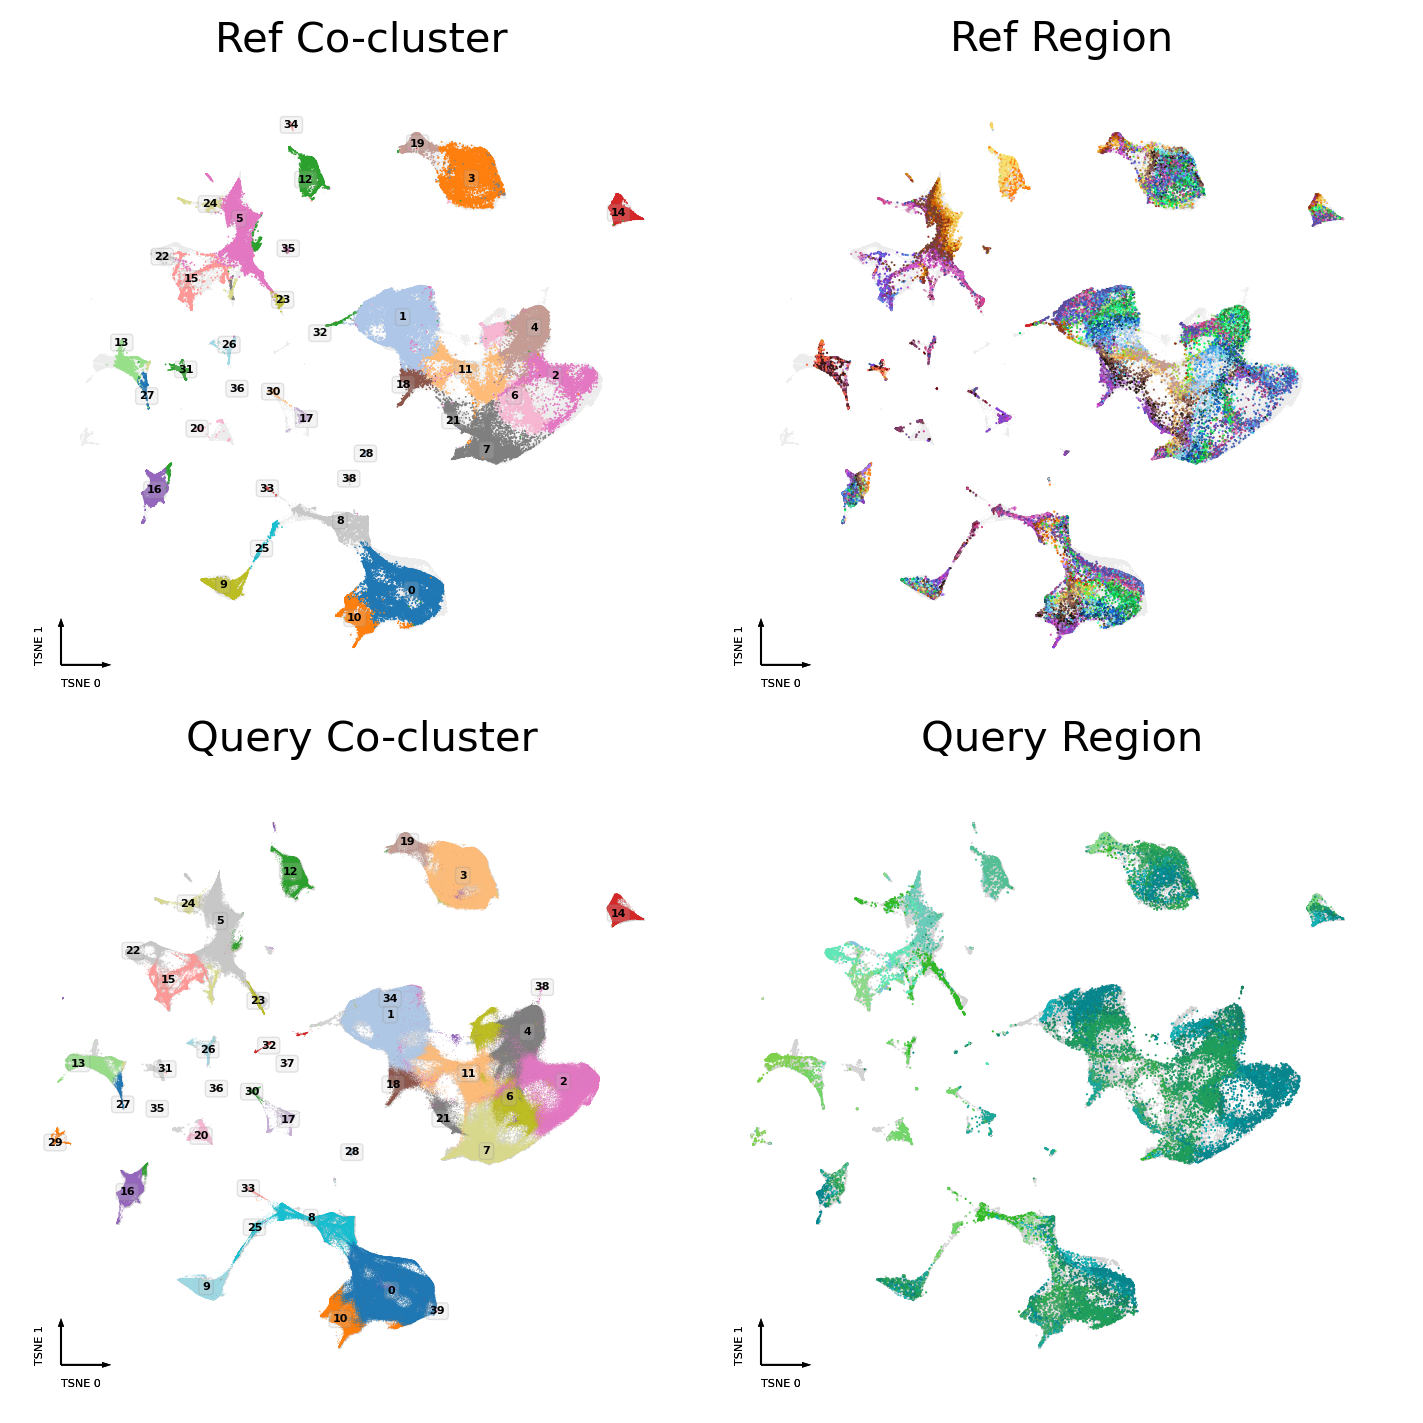

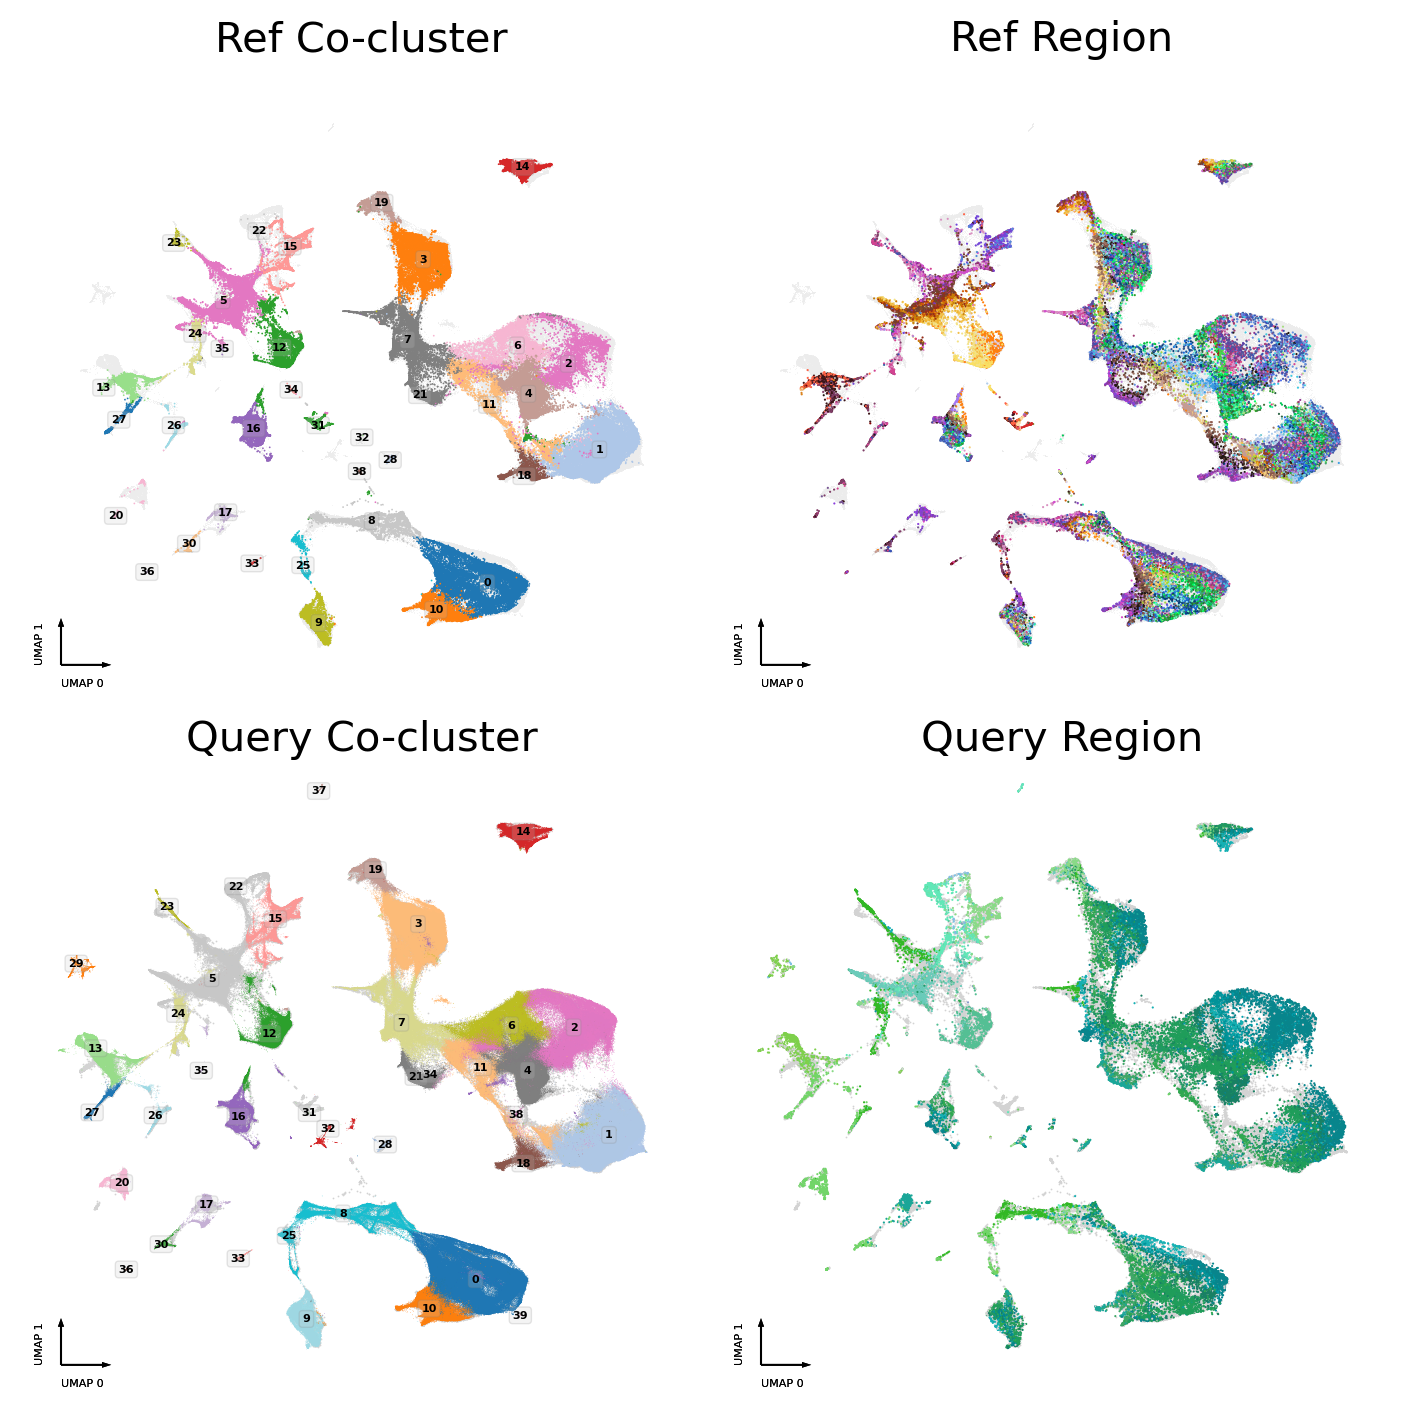

In [13]:
for coord_base in ['tsne', 'umap']:
    fig, axes = plt.subplots(nrows=2,
                             ncols=2,
                             figsize=(7, 7),
                             dpi=200,
                             constrained_layout=True)

    ax = axes[0, 0]
    categorical_scatter(data=rna_data,
                        coord_base=coord_base,
                        max_points=None,
                        hue=None,
                        scatter_kws=dict(color='lightgrey'),
                        ax=ax)
    categorical_scatter(
        data=mc_data,
        ax=ax,
        coord_base=coord_base,
        hue='leiden',
        text_anno='leiden',
        palette='tab20',
        max_points=None,
    )

    ax = axes[0, 1]
    categorical_scatter(data=rna_data,
                        coord_base=coord_base,
                        max_points=None,
                        hue=None,
                        scatter_kws=dict(color='lightgrey'),
                        ax=ax)
    region_palette_1 = brain.get_dissection_region_palette(ref_region_type)
    categorical_scatter(
        data=mc_data,
        ax=ax,
        coord_base=coord_base,
        hue='DissectionRegion',
        palette=region_palette_1,
    )

    ax = axes[1, 0]
    categorical_scatter(data=mc_data,
                        coord_base=coord_base,
                        max_points=None,
                        hue=None,
                        scatter_kws=dict(color='lightgrey'),
                        ax=ax)
    categorical_scatter(
        data=rna_data,
        ax=ax,
        coord_base=coord_base,
        hue='leiden',
        text_anno='leiden',
        palette='tab20',
        max_points=None,
    )

    ax = axes[1, 1]
    categorical_scatter(data=mc_data,
                        coord_base=coord_base,
                        max_points=None,
                        hue=None,
                        scatter_kws=dict(color='lightgrey'),
                        ax=ax)
    region_palette_2 = brain.get_dissection_region_palette(query_region_type)
    categorical_scatter(
        data=rna_data,
        ax=ax,
        coord_base=coord_base,
        hue='DissectionRegion',
        palette=region_palette_2,
    )

    for i, xx in enumerate([
            'Ref Co-cluster', 'Ref Region',
            'Query Co-cluster', 'Query Region'
    ]):
        axes.flatten()[i].set_title(xx, fontsize=15)
    

## Save

In [14]:
adata_merge.write_h5ad('final_with_coords.h5ad')

In [15]:
adata_merge

AnnData object with n_obs × n_vars = 1536223 × 6231
    obs: 'count', 'umi_count', 'n_counts', 'Modality', 'L2', 'DissectionRegion', 'leiden'
    var: 'chrom', 'name-RNA', 'start-RNA', 'end-RNA', 'mean-RNA', 'std-RNA', 'start-mC', 'end-mC', 'cov_mean-mC', 'cef-mC'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca_integrate', 'X_harmony', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

In [16]:
import subprocess
subprocess.run(['rm', '-f', 'final.h5ad'])

CompletedProcess(args=['rm', '-f', 'final.h5ad'], returncode=0)